# Deconvolution of Kripton data

Deconvolution of Kripton data

In [2]:
import matplotlib
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from DBLR_cal import BLRc
from IPython.display import Image
from IPython.core.display import HTML 
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import system_of_units as units
import tables
import mplFunctions as mpl
import wfmFunctions as wfm

In [4]:
import FEE as FE

In [5]:
from scipy import signal

In [6]:
import time

In [7]:
import pandas as pd

## Revised on:

In [8]:
print(time.strftime("%d/%m/%Y"))

06/11/2016


In [9]:
print(time.strftime("%H:%M:%S"))

14:57:21


In [10]:
def wait():
    """
    A simple convenience name for raw_input
    """
    raw_input("Press a key...")

###  Code exercized

In [11]:
!pep8 ../Sierpe/FEE.py

In [12]:
!pyflakes ../Sierpe/FEE.py

In [13]:
yield_factor = 574./690.
print('Yield factor (MC to NEW running conditions, November, 2016 = {})'.format(yield_factor))

Yield factor (MC to NEW running conditions, November, 2016 = 0.831884057971)


### Deconvolution function

#### coeff_clean = freq_zerod

Nominal values:


C1=3100 nF

R1=1567 ohm

f_sample = (1/25 ns)

freq_zero = 1/(R1*C1);

freq_zerod = freq_zero / (f_sample*np.pi)

#### coef_blr=fee.freq_LHPFd*np.pi

freq_LHPFd = freq_LHPF/(f_sample*np.pi)

freq_LHPF = 1./(R * C)

In [14]:
def find_baseline(signal_i, mau_len=1000):

    """
    1) compute baseline using the first blevt events
    2) compute noise rms using first blevt events

    """
    
    nm = mau_len
    len_signal_i = len(signal_i)
    mau = np.zeros(nm, dtype=np.double)
    bmau = (1./nm)*np.ones(nm)

#   MAU averages the signal in the initial tranch
#    allows to compute the baseline of the signal

    mau = signal.lfilter(bmau,1, signal_i[0:nm])
    baseline = mau[nm-1]
    noise_rms = np.std(signal_i[0:nm],ddof=1)
    print ("baseline = {} noise (LSB_rms) = {}".format(baseline, noise_rms))
    return baseline, noise_rms

In [185]:
def deconvolve_signal(signal_daq, mau_len=1000, 
                      coef_clean=2.905447E-06, coef_blr=1.632411E-03, 
                      thr1=5, thr2=1, thr3=1,
                      filter_c=True, kmin=0, kmax = 0):
    """
    Deconvolve the signal. 
    1) compute the baseline and the noise rms
    2) clean the signal
    3) apply BLR
    """
    coef = coef_blr
    nm = mau_len
    len_signal_daq = len(signal_daq)
    signal_r = np.zeros(len_signal_daq, dtype=np.double)
    MAU = np.zeros(len_signal_daq, dtype=np.double)
    acum = np.zeros(len_signal_daq, dtype=np.double)
    pulse_on = np.zeros(len_signal_daq, dtype=np.int8)
    wait_over = np.zeros(len_signal_daq, dtype=np.int8)
    trigger_1 = np.zeros(len_signal_daq, dtype=np.double)
    trigger_2 = np.zeros(len_signal_daq, dtype=np.double)
    
    
    BASELINE, noise_rms = find_baseline(signal_daq, mau_len=nm)
    MAU[0:nm] = BASELINE
    
    # change sign and subtract baseline
    signal_daq =  BASELINE - signal_daq
 
    # clean function
    if (filter==True):
        b_cf, a_cf = signal.butter(1, coef_clean, 'high', analog=False);
        signal_daq = signal.lfilter(b_cf,a_cf,signal_daq)
 
    # BLR
    signal_r[0:nm] = signal_daq[0:nm] 
    p_on = 0
    w_over = 0 
    offset = 0
    
    trigger_line = thr1*noise_rms
    trigger_off = thr2*noise_rms
    print('trigger_line = {} trigger_off = {}'.format(trigger_line, trigger_off))
    
    for k in range(nm,len_signal_daq):
        #trigger_line = MAU[k-1] + thr1*noise_rms
        #trigger_off = MAU[k-1] + thr2*noise_rms
        pulse_on[k] = p_on
        wait_over[k] = w_over
        trigger_1[k] = trigger_line
        trigger_2[k] = trigger_off
                                                                          
        # condition: raw signal raises above trigger line and
        # we are not in the tail
        # (w_over == 0)
        
        #if k > kmin and k < kmax:
        #    print("""k = {} pulse_on = {} wait_over ={}, signal_daq = {} signal_r = {}
        #    """.format(k, pulse_on[k-1], wait_over[k-1], signal_daq[k-1], signal_r[k-1]))
            
        if signal_daq[k] > trigger_line and w_over == 0:

            # if the pulse just started pulse_on = 0.
            # In this case compute the offset as value
            # of the MAU before pulse starts (at k-1)

            if p_on == 0: # pulse just started
                offset = MAU[k-1]
                p_on = 1

            # Pulse is on: Freeze the MAU
            MAU[k] = MAU[k-1]

            #update recovered signal, correcting by offset
            signal_r[k] = signal_daq[k] + signal_daq[k]*(coef/2.0) + coef*acum[k-1] 
            acum[k] = acum[k-1] + signal_daq[k] - offset
            
        else:  # signal_daq[k] < trigger_line and w_over == 1

        # but raw signal can be negative for a while and still contribute to the
        # reconstructed signal.

            if p_on == 1: # reconstructed signal still on
                # switch the pulse off only when recovered signal
                # drops below threshold
                # slide the MAU, still frozen.
                # keep recovering signal

                MAU[k] = MAU[k-1]
                signal_r[k] = signal_daq[k] + signal_daq[k]*(coef/2.0) + coef*acum[k-1] 
                acum[k] = acum[k-1] + signal_daq[k] - offset
                
                # if the recovered signal drops before trigger line
                # rec pulse is over!
                
                if signal_r[k] < trigger_off:
                    w_over = 1  #start tail compensation
                    p_on = 0   #recovered pulse is over


            else:  # recovered signal has droped below trigger line
            # need to compensate the tail to avoid drifting due to erros in
            # baseline calculatoin

                if w_over == 1: # compensating pulse
                    # recovered signal and raw signal
                    # must be equal within a threshold
                    # otherwise keep compensating pluse

                    if abs(signal_daq[k-1] - signal_r[k-1]) > thr3*noise_rms:
                        # raw signal still not close to recovered signal
                        # keep compensating pulse
                        
                        signal_r[k] = signal_daq[k] + signal_daq[k]*(coef/2.0) +\
                                      coef*acum[k-1] 
                        acum[k] = acum[k-1] + signal_daq[k] - offset

                    else:  # raw signal ~=  recovered signal: we are done

                        w_over = 0
                        acum[k] = MAU[k-1]
                        signal_r[k] = signal_daq[k]
                        MAU[k] = np.mean(signal_daq[k-nm:k]*1.)


                else: #signal still not found

                    # update MAU and signals
                    MAU[k] = np.mean(signal_daq[k-nm:k]*1.)
                    acum[k] = MAU[k-1]
                    signal_r[k] = signal_daq[k]
    
    sm = np.amax(signal_r)
    BLR={}
    BLR['acum'] = acum
    BLR['pulse_on'] = pulse_on
    BLR['wait_over'] = wait_over
    BLR['MAU'] = MAU
    BLR['trigger_1'] = trigger_1
    BLR['trigger_2'] = trigger_2
    BLR['signal_daq'] = signal_daq
    BLR['sm'] = sm
                    

    return  signal_r, BLR

#### List the files

In [16]:
ls /Users/jjgomezcadenas/Documents/Development/NEXT/icdata

IC_Kr_500evt.h5
dst_NEXT_v0_08_04_Kr_ACTIVE_0_0_5bar_MCRD_10000.root.h5
dst_NEXT_v0_08_04_Na_ACTIVE_0_0_5bar_MCRD_10000.root.h5
dst_NEXT_v0_08_04_Tl_SOURCE_PORT_ANODE_0_0_5bar_MCRD_10000.root.h5
electrons.1250.0keV.z250mm.next_10.root.h5
electrons.1250.0keV.z250mm.next_100.root.h5
electrons.1250.0keV.z250mm.next_1000.root.h5
electrons.2500.0keV.z250mm.next_10.root.h5
electrons.2500.0keV.z250mm.next_100.root.h5
electrons.2500.0keV.z250mm.next_1000.root.h5
electrons.2500.0keV.z250mm.next_10000.root.h5
electrons.40.0keV.z250mm.next_10.root.h5
electrons.40.0keV.z250mm.next_100.root.h5
electrons.40.0keV.z250mm.next_1000.root.h5
electrons.40.0keV.z250mm.next_10000.root.h5
run_2609_kr.root.h5
run_2644.gdc1next.000.next1el_2644.root.h5
run_2644.gdc1next.001.next1el_2644.root.h5
run_2644.gdc1next.003.next1el_2644.root.h5
run_2644.gdc1next.004.next1el_2644.root.h5
run_2644.gdc1next.005.next1el_2644.root.h5
run_2644.gdc1next.006.next1el_2644.root.h5
run_2644.gdc1next.007.next1el_2644.root.h5
run_

#### Open and inspect files

In [189]:
e40 = tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/electrons.40.0keV.z250mm.next_1000.root.h5','r+')

In [17]:
kr2609 = tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/run_2609_kr.root.h5','r+')

In [18]:
kr2609

File(filename=/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/run_2609_kr.root.h5, title='', mode='r+', root_uep='/', filters=Filters(complevel=4, complib='zlib', shuffle=True, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/Detector (Group) ''
/Detector/DetectorGeometry (Table(1,)) ''
  description := {
  "x_det": Float32Col(shape=(2,), dflt=0.0, pos=0),
  "y_det": Float32Col(shape=(2,), dflt=0.0, pos=1),
  "z_det": Float32Col(shape=(2,), dflt=0.0, pos=2),
  "r_det": Float32Col(shape=(), dflt=0.0, pos=3)}
  byteorder := 'little'
  chunkshape := (2340,)
/RD (Group) ''
/RD/pmtblr (EArray(1365, 12, 48000), shuffle, zlib(4)) ''
  atom := Int16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 5, 48000)
/RD/pmtrwf (EArray(1365, 12, 48000), shuffle, zlib(4)) ''
  atom := Int16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 5, 48000)
/RD/sipmrwf (EArray(1365, 17

## Calibration data

In [23]:
pmtID = ['1','3','2','4','C','B','A','9','8','7','6','5']
elecID = [0,18,1,19,27,26,9,8,23,22,5,4]
noise_rms = [0.706,0.8744,0.7213,0.7624,0.7921,0.866,0.7062,0.7278,0.7303,0.716,0.7323,0.7206]
coef_c = [2.905447E-06,3.08E-06,2.8006E-06,2.756265E-06,3.138766E-06,3.965176E-06,
          3.127641E-06,3.064543E-06,3.040463E-06,3.113604E-06,3.185979E-06]
coef_blr = [1.632411E-03,1.632411E-03,1.611104E-03,1.599356E-03,1.566958E-03,1.649618E-03,
            1.592963E-03,1.612068E-03,1.600683E-03,1.592718E-03,1.575192E-03,1.596322E-03]

In [225]:
dataPMT = pd.DataFrame({'pmtID': pmtID,'elecID': elecID,'noise_rms': noise_rms,
              'coef_c': coef_c,'coef_blr': coef_blr})

In [226]:
dataPMT

,coef_blr,coef_c,elecID,noise_rms,pmtID
0,0.001632,0.000003,0,0.7060,1
1,0.001632,0.000003,18,0.8744,3
2,0.001611,0.000003,1,0.7213,2
3,0.001599,0.000003,19,0.7624,4
4,0.001567,0.000003,27,0.7921,C
5,0.001650,0.000004,26,0.8660,B
6,0.001593,0.000003,9,0.7062,A
7,0.001612,0.000003,8,0.7278,9
8,0.001601,0.000003,23,0.7303,8
9,0.001593,0.000003,22,0.7160,7


## Testing new deconvolution with Kripton data

In [19]:
pmtrwf = kr2609.root.RD.pmtrwf

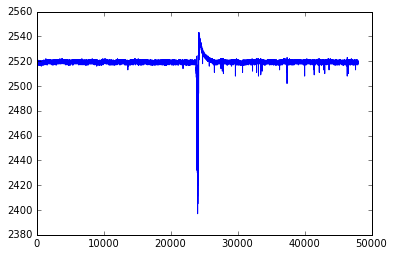

In [20]:
plt.plot(pmtrwf[0,0])

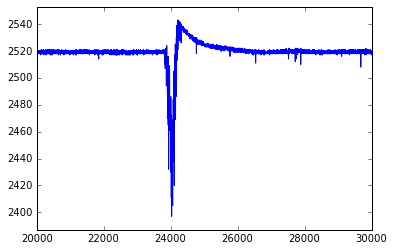

In [21]:
mpl.plts(pmtrwf[0,0], signal_start=20000, signal_end=30000, offset=10)

## Approach 1: thr3 = 1

This approach results in a step at the end of the signal, but the accumulator is stable.

In [86]:
signal_r, BLR = deconvolve_signal(pmtrwf[0,0], mau_len=128, 
                                  coef_clean=dataPMT['coef_c'][0], 
                                  coef_blr=dataPMT['coef_blr'][0], 
                                  thr1 = 5, thr2 = 0, thr3=1.0, filter_c=True,
                                  kmin=23850, kmax=23850)

baseline = 2519.0546875 noise (LSB_rms) = 0.756167228828
trigger_line = 3.78083614414 trigger_off = 0.0


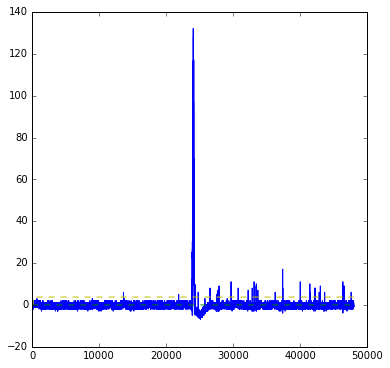

In [63]:
plt.figure(figsize=(6, 6))
xmin=0
xmax=48000
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
#plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['trigger_2'][xmin:xmax],'g--', linewidth=1)

#### S1 likes

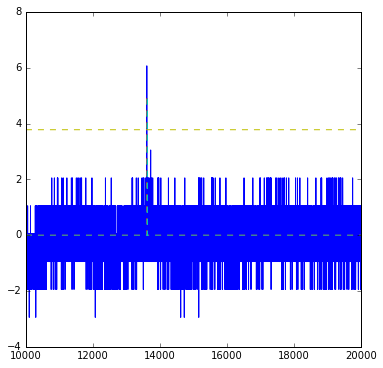

In [64]:
plt.figure(figsize=(6, 6))
xmin=10000
xmax=20000
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
#plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*5,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*5,'c--', linewidth=1)

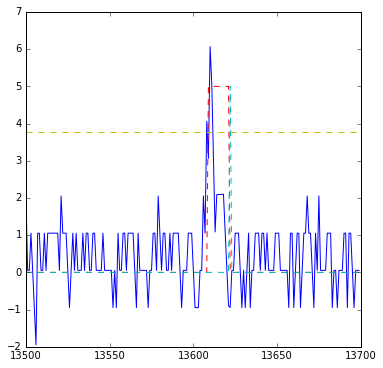

In [65]:
plt.figure(figsize=(6, 6))
xmin=13500
xmax=13700
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
#plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*5,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*5,'c--', linewidth=1)

Pulse_on is activated by the S1 above threshold, and switched off as soon as the spike returns to the baseline. Wait_over also switches off immediately since signal_r and signa_daq are identical at this point

### Start of S2

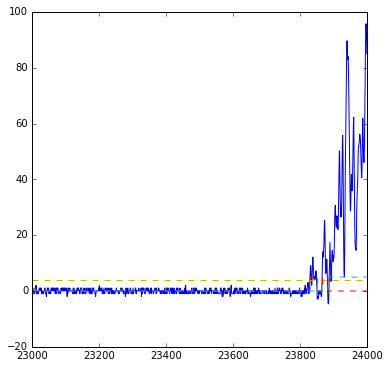

In [48]:
plt.figure(figsize=(6, 6))
xmin=23000
xmax=24000
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
#plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*5,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*5,'c--', linewidth=1)

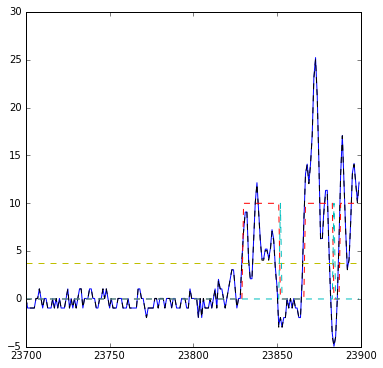

In [66]:
plt.figure(figsize=(6, 6))
xmin=23700
xmax=23900
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*10,'c--', linewidth=1)

pulse_on (wait_over) triggers on and off several times, following the natural fluctuations of the signal. Raw signal and recovered signal are still identical. 

### pulse on =1

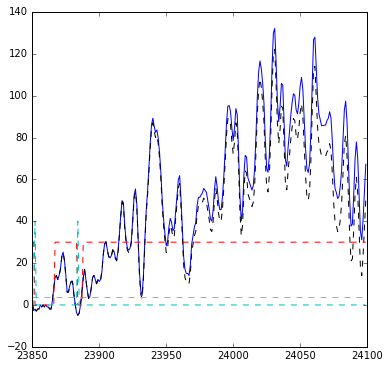

In [71]:
plt.figure(figsize=(6, 6))
xmin=23850
xmax=24100
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*30,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*40,'c--', linewidth=1)

Signal has raised aboved threshold and pulse develops. The recovered signal keeps growing above DAQ signal.

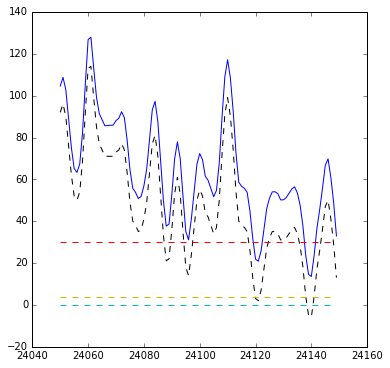

In [72]:
plt.figure(figsize=(6, 6))
xmin=24050
xmax=24150
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*30,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*40,'c--', linewidth=1)

### Wait over starts

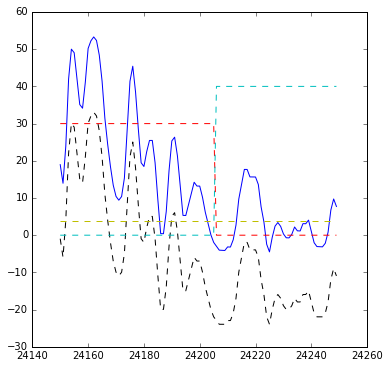

In [74]:
plt.figure(figsize=(6, 6))
xmin=24150
xmax=24250
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*30,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*40,'c--', linewidth=1)

The recovered signal crosses threshod and pulse_on switches off. Now the pulse continues recovering until the difference between the recovered signal and the raw signal is less than
~1 noise_rms

### Wait over

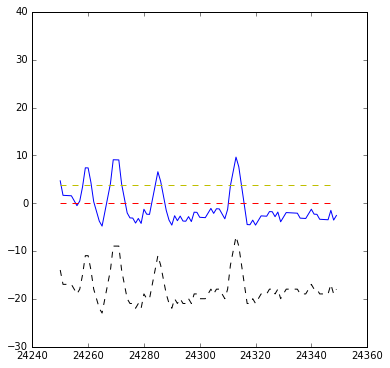

In [82]:
plt.figure(figsize=(6, 6))
xmin=24250
xmax=24350
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*30,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*40,'c--', linewidth=1)

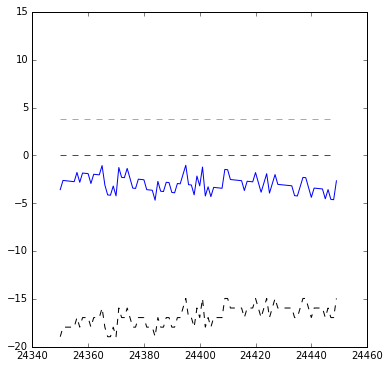

In [84]:
plt.figure(figsize=(6, 6))
xmin=24350
xmax=24450
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*15,'c--', linewidth=1)

As the signal raises well above threshold (no more pulse swich on/off), wait_over is 

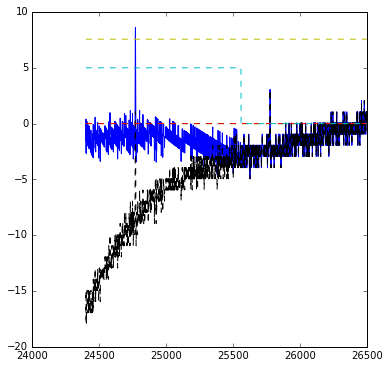

In [550]:
plt.figure(figsize=(6, 6))
xmin = 24400
xmax = 26500
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
#plt.plot(range(xmin,xmax), BLR['MAU'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['trigger_2'][xmin:xmax],'g--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*5,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*5,'c--', linewidth=1)
plt.show()

The recovered signal and the daq_signal meet a few counts below threshold, resulting in a step.

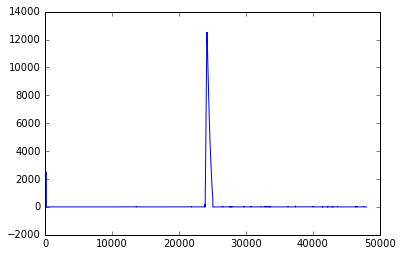

In [85]:
plt.plot(BLR['acum'])

The accumulator is well behaved.

## thr3 < 1

In [92]:
signal_r, BLR = deconvolve_signal(pmtrwf[0,0], mau_len=128, 
                                  coef_clean=dataPMT['coef_c'][0], 
                                  coef_blr=dataPMT['coef_blr'][0], 
                                  thr1 = 5, thr2 = 0, thr3=0.3, filter_c=True,
                                  kmin=23850, kmax=23850)

baseline = 2519.0546875 noise (LSB_rms) = 0.756167228828
trigger_line = 3.78083614414 trigger_off = 0.0


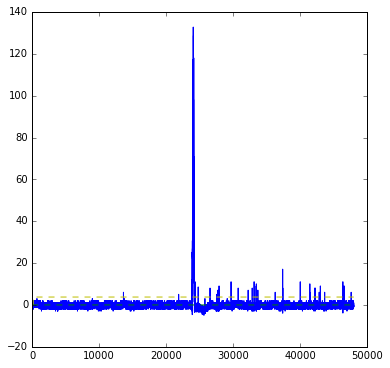

In [93]:
plt.figure(figsize=(6, 6))
xmin=0
xmax=48000
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
#plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['trigger_2'][xmin:xmax],'g--', linewidth=1)

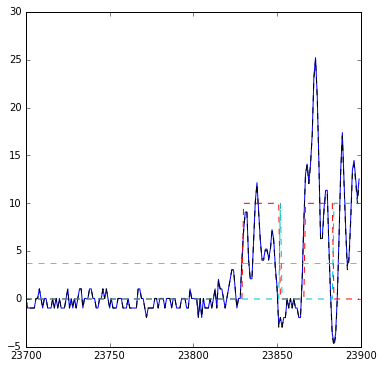

In [94]:
plt.figure(figsize=(6, 6))
xmin=23700
xmax=23900
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*10,'c--', linewidth=1)

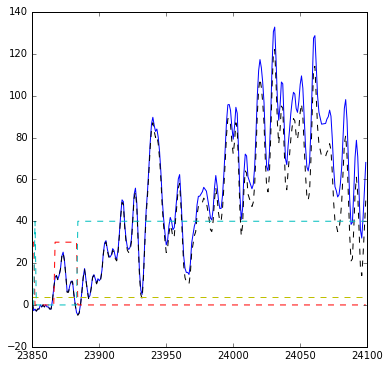

In [95]:
plt.figure(figsize=(6, 6))
xmin=23850
xmax=24100
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*30,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*40,'c--', linewidth=1)

Setting th3 low (0.3) results in "cheating the system into recovery mode" from the start of the pulse. 

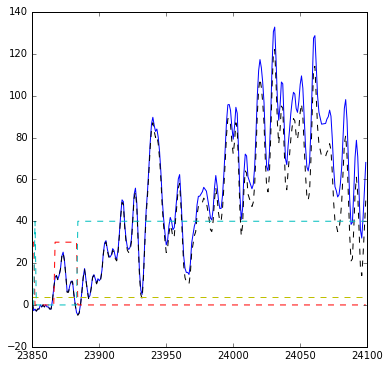

In [96]:
plt.figure(figsize=(6, 6))
xmin=23850
xmax=24100
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*30,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*40,'c--', linewidth=1)

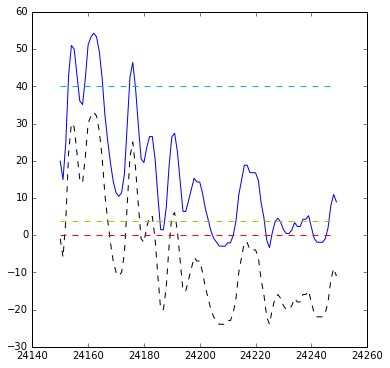

In [97]:
plt.figure(figsize=(6, 6))
xmin=24150
xmax=24250
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*30,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*40,'c--', linewidth=1)

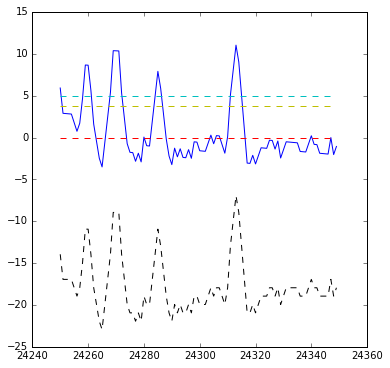

In [100]:
plt.figure(figsize=(6, 6))
xmin=24250
xmax=24350
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*30,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*5,'c--', linewidth=1)

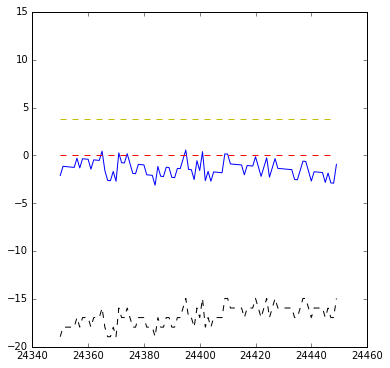

In [101]:
plt.figure(figsize=(6, 6))
xmin=24350
xmax=24450
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*15,'c--', linewidth=1)

recovered signal stays nearer zero

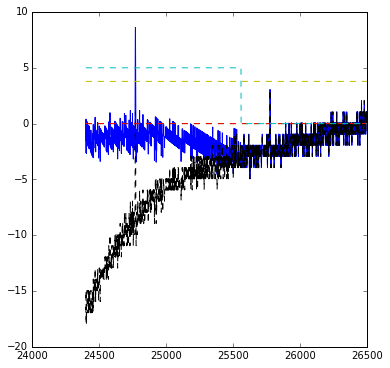

In [102]:
plt.figure(figsize=(6, 6))
xmin = 24400
xmax = 26500
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
#plt.plot(range(xmin,xmax), BLR['MAU'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['trigger_2'][xmin:xmax],'g--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*5,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*5,'c--', linewidth=1)
plt.show()

dip occurs later in the waveform (always needed since one has to adjust to raw waveform)

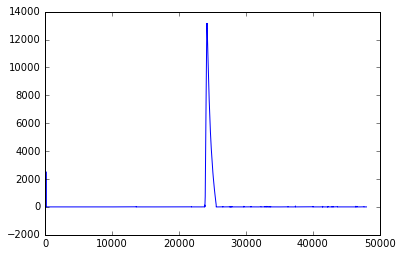

In [103]:
plt.plot(BLR['acum'])

In [104]:
signal_r, BLR = deconvolve_signal(pmtrwf[0,0], mau_len=128, 
                                  coef_clean=dataPMT['coef_c'][0], 
                                  coef_blr=dataPMT['coef_blr'][0], 
                                  thr1 = 5, thr2 = 0, thr3=0.1, filter_c=True,
                                  kmin=23850, kmax=23850)

baseline = 2519.0546875 noise (LSB_rms) = 0.756167228828
trigger_line = 3.78083614414 trigger_off = 0.0


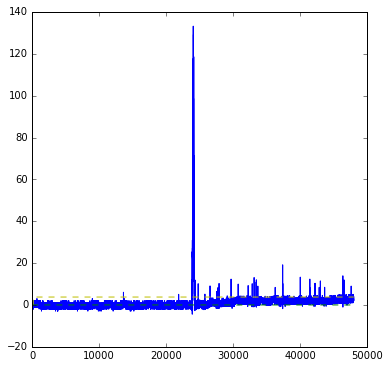

In [105]:
plt.figure(figsize=(6, 6))
xmin=0
xmax=48000
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
#plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['trigger_2'][xmin:xmax],'g--', linewidth=1)

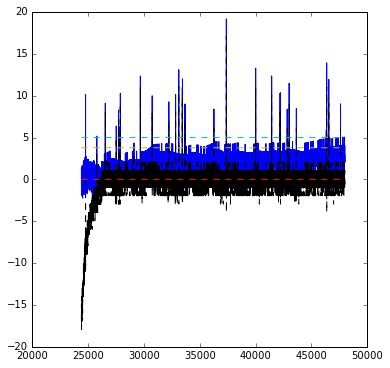

In [111]:
plt.figure(figsize=(6, 6))
xmin = 24400
xmax = 48000
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
#plt.plot(range(xmin,xmax), BLR['MAU'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['trigger_2'][xmin:xmax],'g--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*5,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*5,'c--', linewidth=1)
plt.show()

always in mode wait over (alwasy recovering)

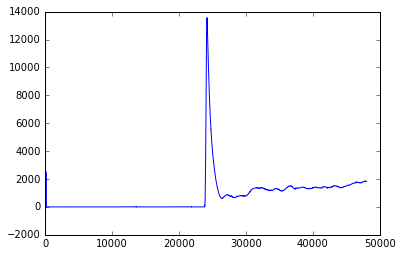

In [112]:
plt.plot(BLR['acum'])

accumlator unstable

In [113]:
signal_r, BLR = deconvolve_signal(pmtrwf[0,0], mau_len=128, 
                                  coef_clean=dataPMT['coef_c'][0], 
                                  coef_blr=dataPMT['coef_blr'][0], 
                                  thr1 = 5, thr2 = 0, thr3=0.2, filter_c=True,
                                  kmin=23850, kmax=23850)

baseline = 2519.0546875 noise (LSB_rms) = 0.756167228828
trigger_line = 3.78083614414 trigger_off = 0.0


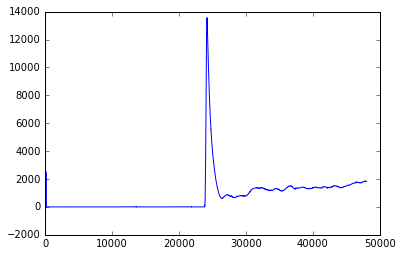

In [114]:
plt.plot(BLR['acum'])

In [115]:
signal_r, BLR = deconvolve_signal(pmtrwf[0,0], mau_len=128, 
                                  coef_clean=dataPMT['coef_c'][0], 
                                  coef_blr=dataPMT['coef_blr'][0], 
                                  thr1 = 5, thr2 = 0, thr3=0.3, filter_c=True,
                                  kmin=23850, kmax=23850)

baseline = 2519.0546875 noise (LSB_rms) = 0.756167228828
trigger_line = 3.78083614414 trigger_off = 0.0


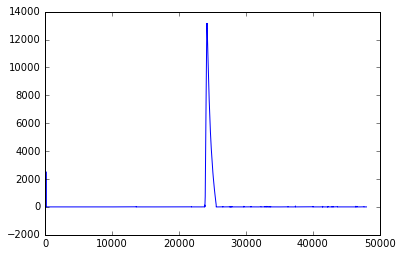

In [116]:
plt.plot(BLR['acum'])

The best value appears to be 0.3

## PMT2

In [227]:
signal_r, BLR = deconvolve_signal(pmtrwf[0,1], mau_len=128, 
                                  coef_clean=dataPMT['coef_c'][1], 
                                  coef_blr=dataPMT['coef_blr'][1], 
                                  thr1 = 5, thr2 = 0, thr3=0.3, filter_c=True,
                                  kmin=23850, kmax=23850)

baseline = 2520.265625 noise (LSB_rms) = 0.757995439705
trigger_line = 3.78997719853 trigger_off = 0.0


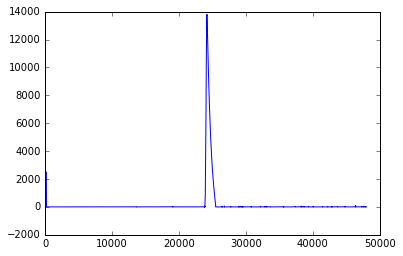

In [228]:
plt.plot(BLR['acum'])

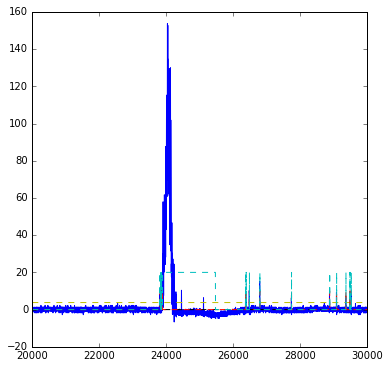

In [229]:
plt.figure(figsize=(6, 6))
xmin=20000
xmax=30000
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
#plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['trigger_2'][xmin:xmax],'k--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*20,'c--', linewidth=1)

## PMT3

In [230]:
signal_r, BLR = deconvolve_signal(pmtrwf[0,2], mau_len=128, 
                                  coef_clean=dataPMT['coef_c'][2], 
                                  coef_blr=dataPMT['coef_blr'][2], 
                                  thr1 = 5, thr2 = 0, thr3=0.3, filter_c=True,
                                  kmin=23850, kmax=23850)

baseline = 2458.828125 noise (LSB_rms) = 0.754089898356
trigger_line = 3.77044949178 trigger_off = 0.0


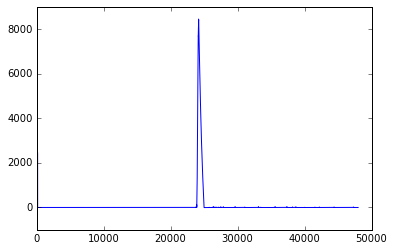

In [231]:
plt.plot(BLR['acum'])

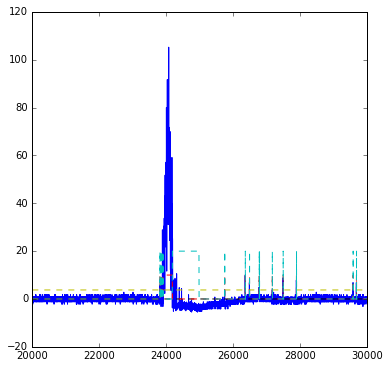

In [232]:
plt.figure(figsize=(6, 6))
xmin=20000
xmax=30000
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
#plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['trigger_2'][xmin:xmax],'k--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*20,'c--', linewidth=1)

## PMT4

In [233]:
signal_r, BLR = deconvolve_signal(pmtrwf[0,3], mau_len=128, 
                                  coef_clean=dataPMT['coef_c'][3], 
                                  coef_blr=dataPMT['coef_blr'][3], 
                                  thr1 = 5, thr2 = 0, thr3=0.3, filter_c=True,
                                  kmin=23850, kmax=23850)

baseline = 2484.609375 noise (LSB_rms) = 0.77596143057
trigger_line = 3.87980715285 trigger_off = 0.0


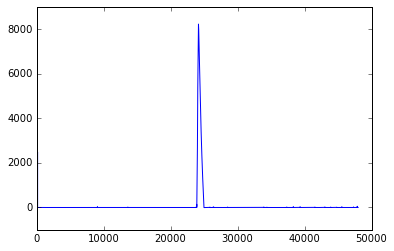

In [234]:
plt.plot(BLR['acum'])

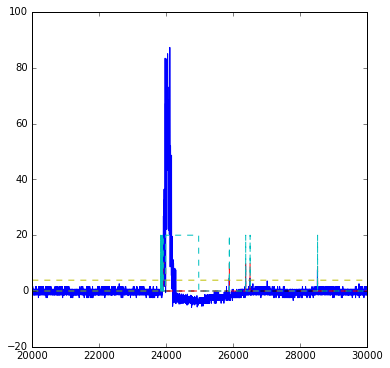

In [235]:
plt.figure(figsize=(6, 6))
xmin=20000
xmax=30000
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
#plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['trigger_2'][xmin:xmax],'k--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*20,'c--', linewidth=1)

## PMT5

In [236]:
signal_r, BLR = deconvolve_signal(pmtrwf[0,4], mau_len=128, 
                                  coef_clean=dataPMT['coef_c'][4], 
                                  coef_blr=dataPMT['coef_blr'][4], 
                                  thr1 = 5, thr2 = 0, thr3=0.3, filter_c=True,
                                  kmin=23850, kmax=23850)

baseline = 2469.8515625 noise (LSB_rms) = 0.794566625304
trigger_line = 3.97283312652 trigger_off = 0.0


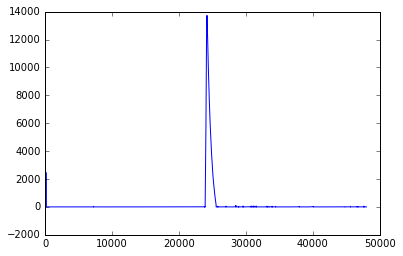

In [237]:
plt.plot(BLR['acum'])

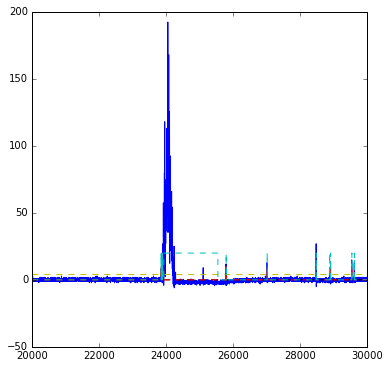

In [157]:
plt.figure(figsize=(6, 6))
xmin=20000
xmax=30000
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
#plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['trigger_2'][xmin:xmax],'k--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*20,'c--', linewidth=1)

## PMT6

In [238]:
signal_r, BLR = deconvolve_signal(pmtrwf[0,5], mau_len=128, 
                                  coef_clean=dataPMT['coef_c'][5], 
                                  coef_blr=dataPMT['coef_blr'][5], 
                                  thr1 = 5, thr2 = 0, thr3=0.3, filter_c=True,
                                  kmin=23850, kmax=23850)

baseline = 2528.4140625 noise (LSB_rms) = 0.808686538359
trigger_line = 4.04343269179 trigger_off = 0.0


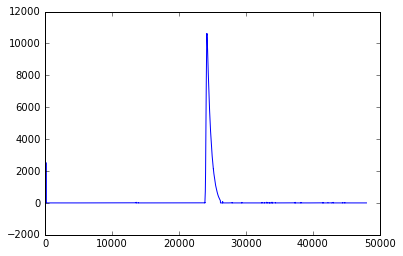

In [239]:
plt.plot(BLR['acum'])

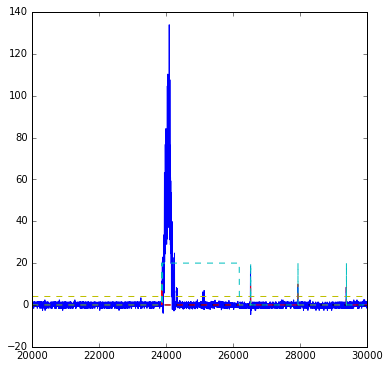

In [160]:
plt.figure(figsize=(6, 6))
xmin=20000
xmax=30000
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
#plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['trigger_2'][xmin:xmax],'k--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*20,'c--', linewidth=1)

## PMT7

In [240]:
signal_r, BLR = deconvolve_signal(pmtrwf[0,6], mau_len=128, 
                                  coef_clean=dataPMT['coef_c'][6], 
                                  coef_blr=dataPMT['coef_blr'][6], 
                                  thr1 = 5, thr2 = 0, thr3=0.3, filter_c=True,
                                  kmin=23850, kmax=23850)

baseline = 2502.7265625 noise (LSB_rms) = 0.760385767718
trigger_line = 3.80192883859 trigger_off = 0.0


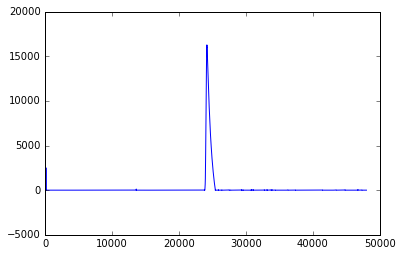

In [241]:
plt.plot(BLR['acum'])

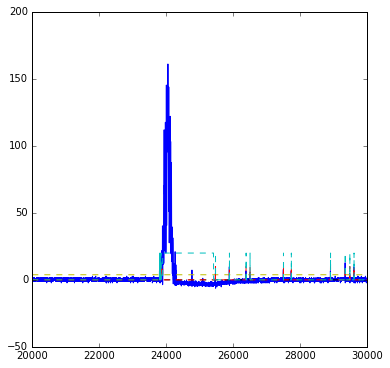

In [242]:
plt.figure(figsize=(6, 6))
xmin=20000
xmax=30000
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
#plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['trigger_2'][xmin:xmax],'k--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*20,'c--', linewidth=1)

## PMT8

In [243]:
signal_r, BLR = deconvolve_signal(pmtrwf[0,7], mau_len=128, 
                                  coef_clean=dataPMT['coef_c'][7], 
                                  coef_blr=dataPMT['coef_blr'][7], 
                                  thr1 = 5, thr2 = 0, thr3=0.3, filter_c=True,
                                  kmin=23850, kmax=23850)

baseline = 2492.5390625 noise (LSB_rms) = 0.719824385298
trigger_line = 3.59912192649 trigger_off = 0.0


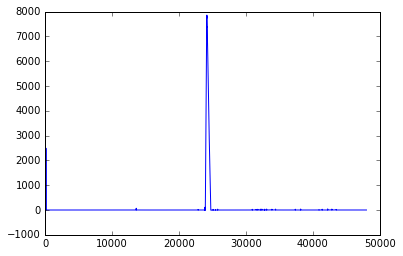

In [244]:
plt.plot(BLR['acum'])

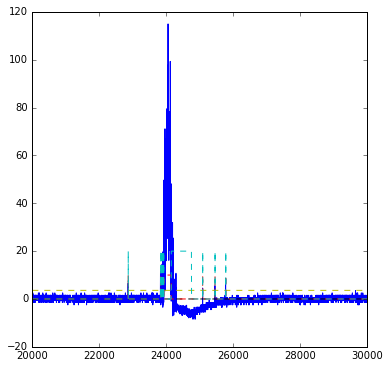

In [245]:
plt.figure(figsize=(6, 6))
xmin=20000
xmax=30000
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
#plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['trigger_2'][xmin:xmax],'k--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*20,'c--', linewidth=1)

## PMT9

In [246]:
signal_r, BLR = deconvolve_signal(pmtrwf[0,8], mau_len=128, 
                                  coef_clean=dataPMT['coef_c'][8], 
                                  coef_blr=dataPMT['coef_blr'][8], 
                                  thr1 = 5, thr2 = 0, thr3=0.3, filter_c=True,
                                  kmin=23850, kmax=23850)

baseline = 2491.328125 noise (LSB_rms) = 0.743574840421
trigger_line = 3.7178742021 trigger_off = 0.0


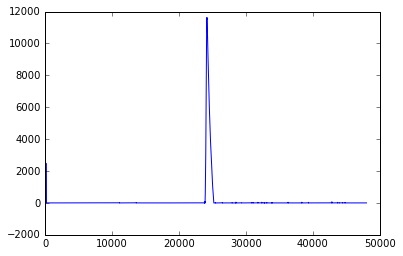

In [247]:
plt.plot(BLR['acum'])

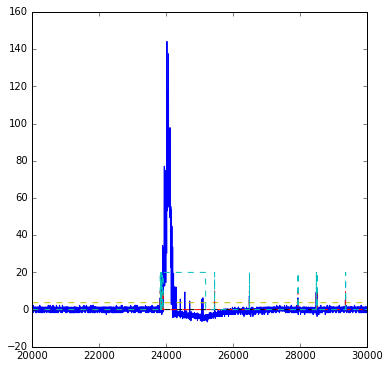

In [248]:
plt.figure(figsize=(6, 6))
xmin=20000
xmax=30000
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
#plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['trigger_2'][xmin:xmax],'k--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*20,'c--', linewidth=1)

## PMT10

In [249]:
signal_r, BLR = deconvolve_signal(pmtrwf[0,9], mau_len=128, 
                                  coef_clean=dataPMT['coef_c'][9], 
                                  coef_blr=dataPMT['coef_blr'][9], 
                                  thr1 = 5, thr2 = 0, thr3=0.3, filter_c=True,
                                  kmin=23850, kmax=23850)

baseline = 2498.890625 noise (LSB_rms) = 0.77596143057
trigger_line = 3.87980715285 trigger_off = 0.0


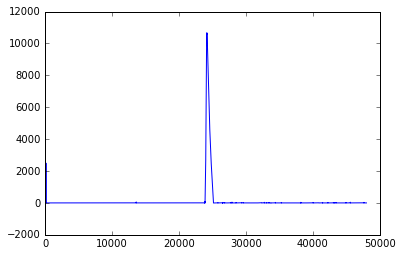

In [250]:
plt.plot(BLR['acum'])

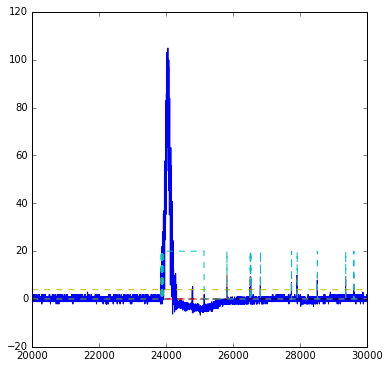

In [251]:
plt.figure(figsize=(6, 6))
xmin=20000
xmax=30000
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
#plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['trigger_2'][xmin:xmax],'k--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*20,'c--', linewidth=1)

## PMT11

In [252]:
signal_r, BLR = deconvolve_signal(pmtrwf[0,10], mau_len=128, 
                                  coef_clean=dataPMT['coef_c'][10], 
                                  coef_blr=dataPMT['coef_blr'][10], 
                                  thr1 = 5, thr2 = 0, thr3=0.3, filter_c=True,
                                  kmin=23850, kmax=23850)

baseline = 2502.1015625 noise (LSB_rms) = 0.730007482973
trigger_line = 3.65003741487 trigger_off = 0.0


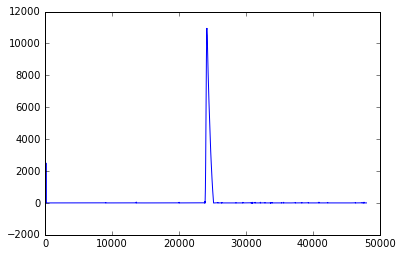

In [253]:
plt.plot(BLR['acum'])

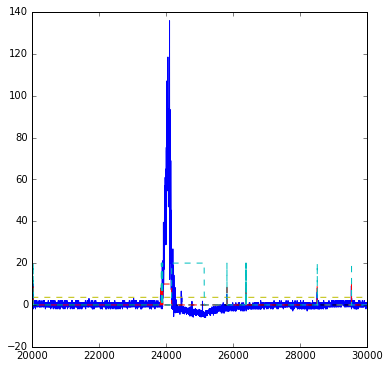

In [254]:
plt.figure(figsize=(6, 6))
xmin=20000
xmax=30000
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
#plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['trigger_2'][xmin:xmax],'k--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*20,'c--', linewidth=1)

## PMT12

In [255]:
signal_r, BLR = deconvolve_signal(pmtrwf[0,11], mau_len=128, 
                                  coef_clean=dataPMT['coef_c'][11], 
                                  coef_blr=dataPMT['coef_blr'][11], 
                                  thr1 = 5, thr2 = 0, thr3=0.3, filter_c=True,
                                  kmin=23850, kmax=23850)

baseline = 2504.6796875 noise (LSB_rms) = 0.720166141702
trigger_line = 3.60083070851 trigger_off = 0.0


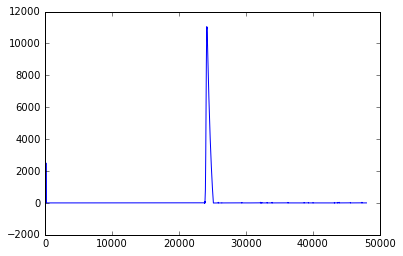

In [179]:
plt.plot(BLR['acum'])

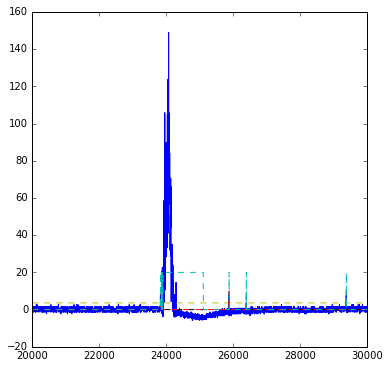

In [256]:
plt.figure(figsize=(6, 6))
xmin=20000
xmax=30000
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
#plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['trigger_2'][xmin:xmax],'k--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*20,'c--', linewidth=1)

### Effect of cleaning not visible for short signals 

In [182]:
def deconv_pmt(pmtrwf,dataPMT, thr1 = 5, thr2=0, thr3=0.5, mau_len=128, 
               xmin=20000,
               xmax=30000, 
               event=0):
    """
    Deconvolution of a full event
    """
    NPMT = pmtrwf.shape[1]
    
    for i in range(NPMT):
        print('PMT number {}'.format(i+1))
        cc = dataPMT['coef_c'][i]
        cblr = dataPMT['coef_blr'][i]
        print('thr1 = {}, thr2 = {}, thr3 = {}, mau length = {}'.format(thr1,thr2, 
                                                                        thr3,mau_len))
        print('deconvoluting PMT = {} with coef_clean = {} coef_blr = {}'.format(i,cc,cblr))
                                                                                
        signal_r, BLR = deconvolve_signal(pmtrwf[event,i], 
                                          mau_len=mau_len, 
                                          coef_clean=cc,
                                          coef_blr=cblr, 
                                          thr1 = thr1, 
                                          thr2=thr2, 
                                          thr3=thr3,
                                          filter_c=True)
        
        plt.plot(BLR['acum'])
        plt.show()
        wait()
        plt.figure(figsize=(6, 6))

        plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
        # plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
        plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
        plt.plot(range(xmin,xmax), BLR['trigger_2'][xmin:xmax],'k--', linewidth=1)
        plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)
        plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*20,'c--', linewidth=1)
        plt.show()
        wait()
        
    

PMT number 1
thr1 = 7, thr2 = 1, thr3 = 0.3, mau length = 128
deconvoluting PMT = 0 with coef_clean = 2.905447e-06 coef_blr = 0.001632411
baseline = 2519.0546875 noise (LSB_rms) = 0.756167228828
trigger_line = 5.29317060179 trigger_off = 0.756167228828


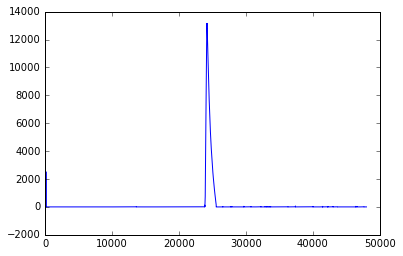

Press a key...


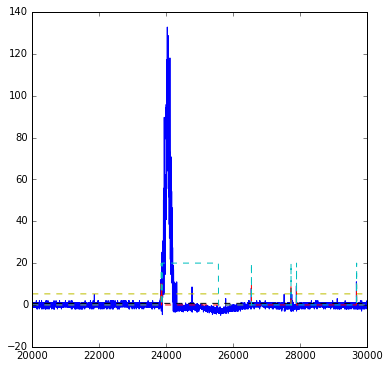

In [ ]:
deconv_pmt(pmtrwf,dataPMT, thr1 = 7, thr2=1, thr3=0.3, mau_len=128, 
           xmin=20000,
           xmax=30000, event=0)

PMT number 1
thr1 = 7, thr2 = 1, thr3 = 0.5, mau length = 128
deconvoluting PMT = 0 with coef_clean = 2.905447e-06 coef_blr = 0.001632411
baseline = 2519.0546875 noise (LSB_rms) = 0.756167228828
trigger_line = 5.29317060179 trigger_off = 0.756167228828


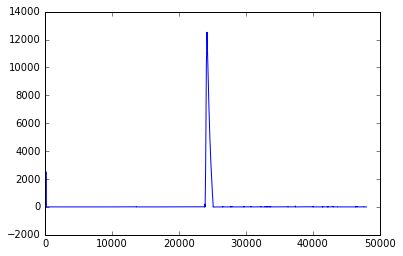

Press a key...


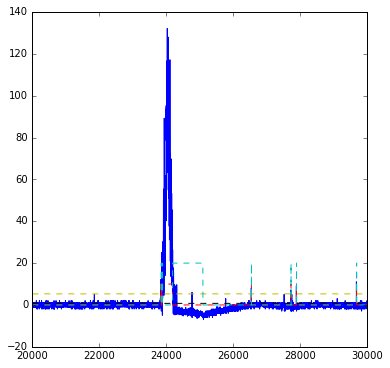

Press a key...
PMT number 2
thr1 = 7, thr2 = 1, thr3 = 0.5, mau length = 128
deconvoluting PMT = 1 with coef_clean = 2.905447e-06 coef_blr = 0.001632411
baseline = 2520.265625 noise (LSB_rms) = 0.757995439705
trigger_line = 5.30596807794 trigger_off = 0.757995439705


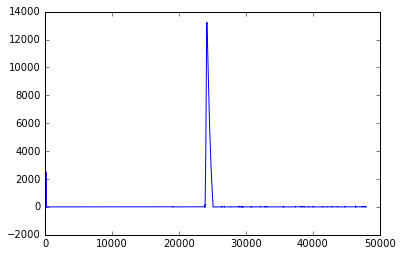

Press a key...


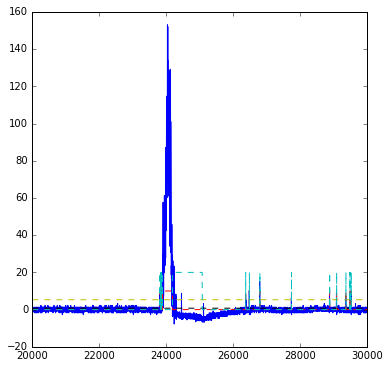

Press a key...
PMT number 3
thr1 = 7, thr2 = 1, thr3 = 0.5, mau length = 128
deconvoluting PMT = 2 with coef_clean = 2.806061e-06 coef_blr = 0.001611104
baseline = 2458.828125 noise (LSB_rms) = 0.754089898356
trigger_line = 5.27862928849 trigger_off = 0.754089898356


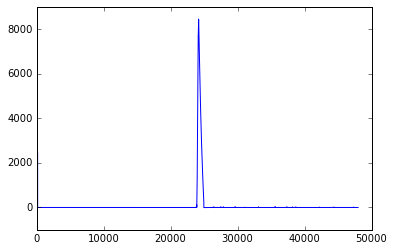

Press a key...


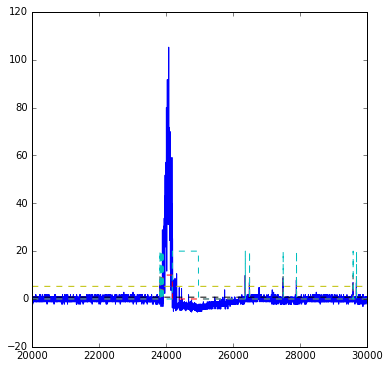

Press a key...
PMT number 4
thr1 = 7, thr2 = 1, thr3 = 0.5, mau length = 128
deconvoluting PMT = 3 with coef_clean = 2.756265e-06 coef_blr = 0.001599356
baseline = 2484.609375 noise (LSB_rms) = 0.77596143057
trigger_line = 5.43173001399 trigger_off = 0.77596143057


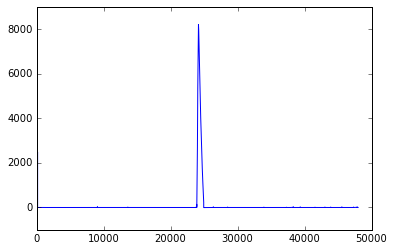

Press a key...


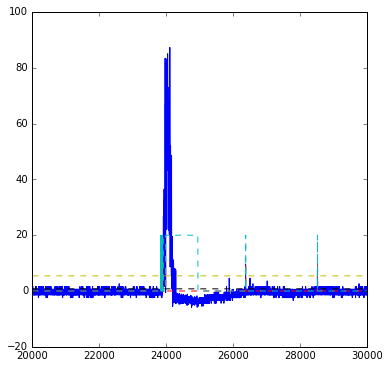

Press a key...
PMT number 5
thr1 = 7, thr2 = 1, thr3 = 0.5, mau length = 128
deconvoluting PMT = 4 with coef_clean = 3.138766e-06 coef_blr = 0.001566958
baseline = 2469.8515625 noise (LSB_rms) = 0.794566625304
trigger_line = 5.56196637713 trigger_off = 0.794566625304


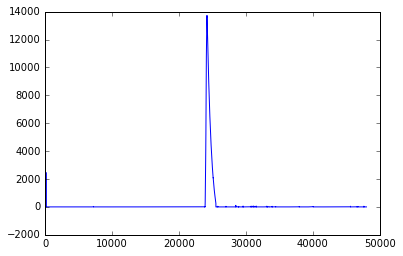

Press a key...


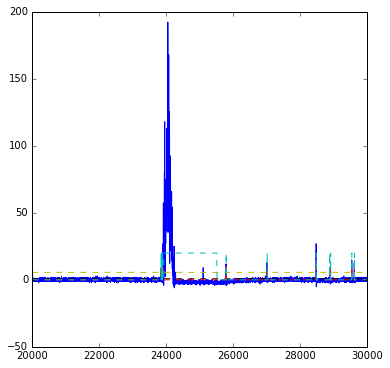

Press a key...
PMT number 6
thr1 = 7, thr2 = 1, thr3 = 0.5, mau length = 128
deconvoluting PMT = 5 with coef_clean = 3.965176e-06 coef_blr = 0.001649618
baseline = 2528.4140625 noise (LSB_rms) = 0.808686538359
trigger_line = 5.66080576851 trigger_off = 0.808686538359


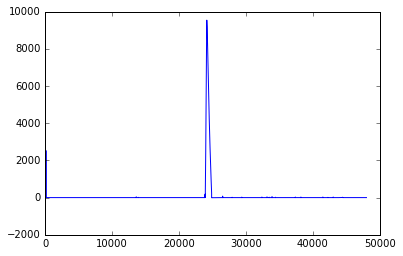

Press a key...


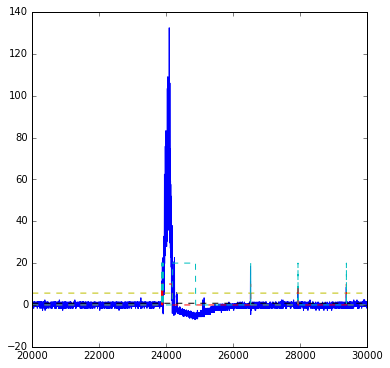

Press a key...
PMT number 7
thr1 = 7, thr2 = 1, thr3 = 0.5, mau length = 128
deconvoluting PMT = 6 with coef_clean = 2.711644e-06 coef_blr = 0.001592963
baseline = 2502.7265625 noise (LSB_rms) = 0.760385767718
trigger_line = 5.32270037403 trigger_off = 0.760385767718


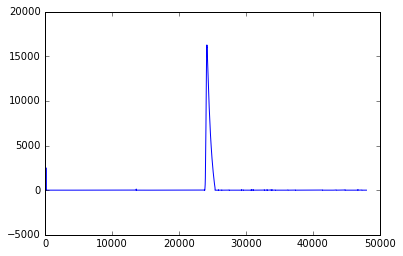

Press a key...


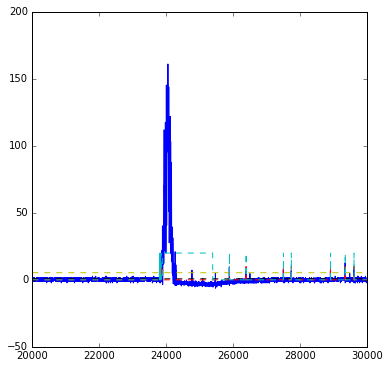

Press a key...
PMT number 8
thr1 = 7, thr2 = 1, thr3 = 0.5, mau length = 128
deconvoluting PMT = 7 with coef_clean = 3.127641e-06 coef_blr = 0.001612068
baseline = 2492.5390625 noise (LSB_rms) = 0.719824385298
trigger_line = 5.03877069708 trigger_off = 0.719824385298


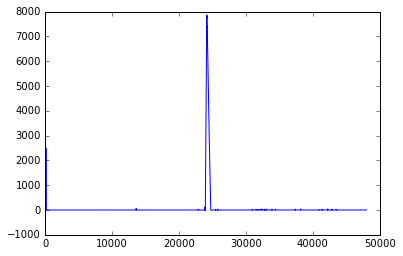

Press a key...


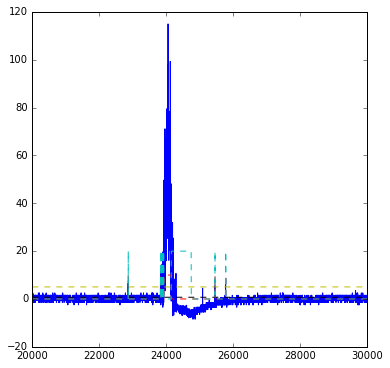

Press a key...
PMT number 9
thr1 = 7, thr2 = 1, thr3 = 0.5, mau length = 128
deconvoluting PMT = 8 with coef_clean = 3.064543e-06 coef_blr = 0.001600683
baseline = 2491.328125 noise (LSB_rms) = 0.743574840421
trigger_line = 5.20502388295 trigger_off = 0.743574840421


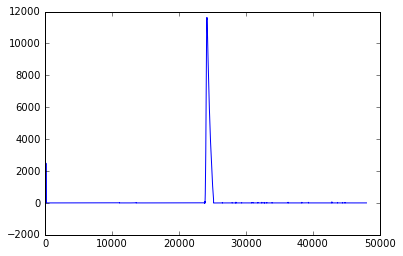

Press a key...


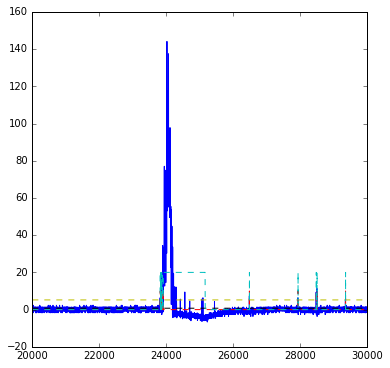

Press a key...
PMT number 10
thr1 = 7, thr2 = 1, thr3 = 0.5, mau length = 128
deconvoluting PMT = 9 with coef_clean = 3.040463e-06 coef_blr = 0.001592718
baseline = 2498.890625 noise (LSB_rms) = 0.77596143057
trigger_line = 5.43173001399 trigger_off = 0.77596143057


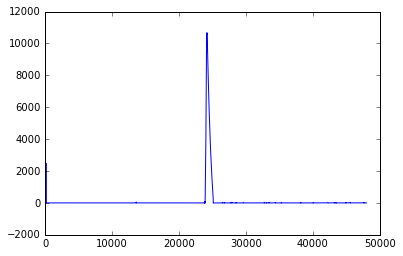

Press a key...


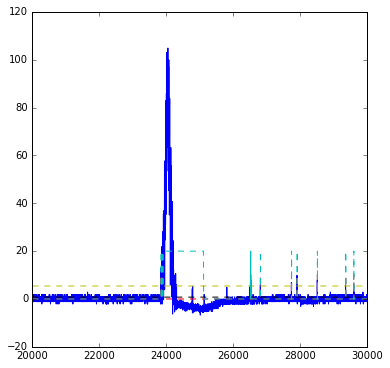

Press a key...
PMT number 11
thr1 = 7, thr2 = 1, thr3 = 0.5, mau length = 128
deconvoluting PMT = 10 with coef_clean = 3.113604e-06 coef_blr = 0.001575192
baseline = 2502.1015625 noise (LSB_rms) = 0.730007482973
trigger_line = 5.11005238081 trigger_off = 0.730007482973


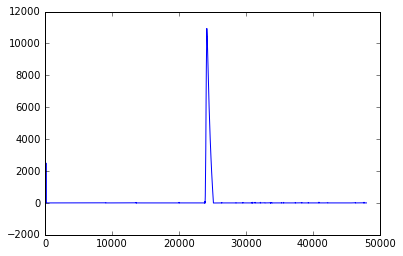

Press a key...


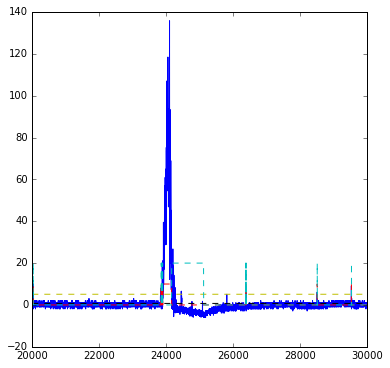

Press a key...
PMT number 12
thr1 = 7, thr2 = 1, thr3 = 0.5, mau length = 128
deconvoluting PMT = 11 with coef_clean = 3.185979e-06 coef_blr = 0.001596322
baseline = 2504.6796875 noise (LSB_rms) = 0.720166141702
trigger_line = 5.04116299191 trigger_off = 0.720166141702


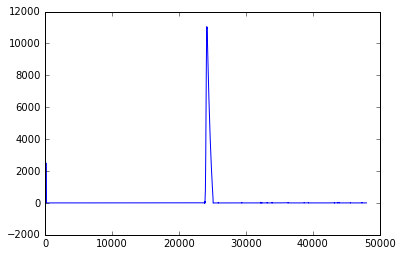

Press a key...


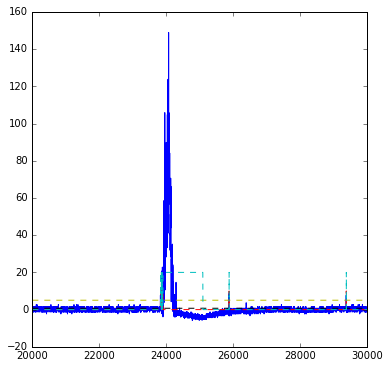

Press a key...


In [187]:
deconv_pmt(pmtrwf,dataPMT, thr1 = 7, thr2=1, thr3=0.5, mau_len=128, 
           xmin=20000,
           xmax=30000, event=0)

PMT number 1
thr1 = 7, thr2 = 1, thr3 = 1.0, mau length = 128
deconvoluting PMT = 0 with coef_clean = 2.905447e-06 coef_blr = 0.001632411
baseline = 2519.0546875 noise (LSB_rms) = 0.756167228828
trigger_line = 5.29317060179 trigger_off = 0.756167228828


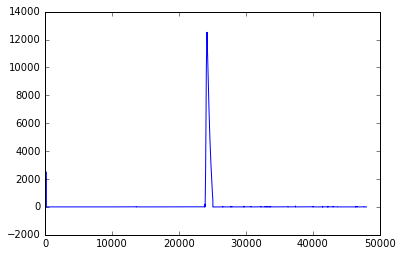

Press a key...


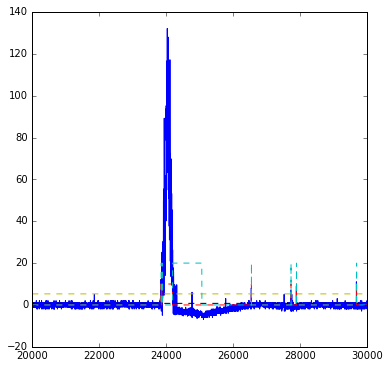

Press a key...
PMT number 2
thr1 = 7, thr2 = 1, thr3 = 1.0, mau length = 128
deconvoluting PMT = 1 with coef_clean = 2.905447e-06 coef_blr = 0.001632411
baseline = 2520.265625 noise (LSB_rms) = 0.757995439705
trigger_line = 5.30596807794 trigger_off = 0.757995439705


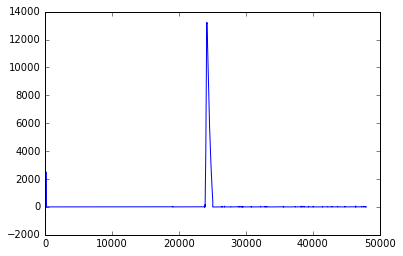

Press a key...


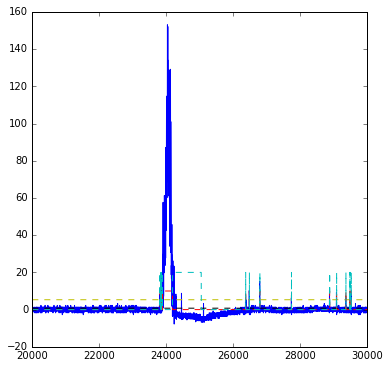

Press a key...
PMT number 3
thr1 = 7, thr2 = 1, thr3 = 1.0, mau length = 128
deconvoluting PMT = 2 with coef_clean = 2.806061e-06 coef_blr = 0.001611104
baseline = 2458.828125 noise (LSB_rms) = 0.754089898356
trigger_line = 5.27862928849 trigger_off = 0.754089898356


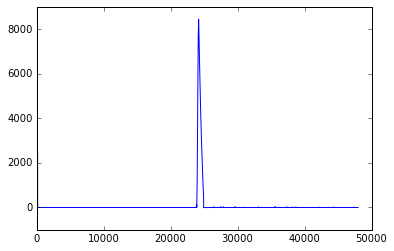

Press a key...


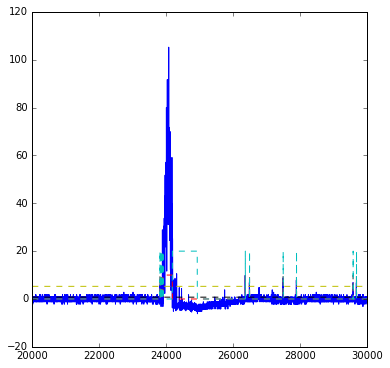

Press a key...
PMT number 4
thr1 = 7, thr2 = 1, thr3 = 1.0, mau length = 128
deconvoluting PMT = 3 with coef_clean = 2.756265e-06 coef_blr = 0.001599356
baseline = 2484.609375 noise (LSB_rms) = 0.77596143057
trigger_line = 5.43173001399 trigger_off = 0.77596143057


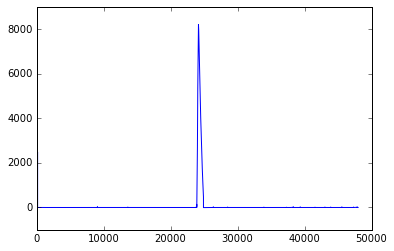

Press a key...


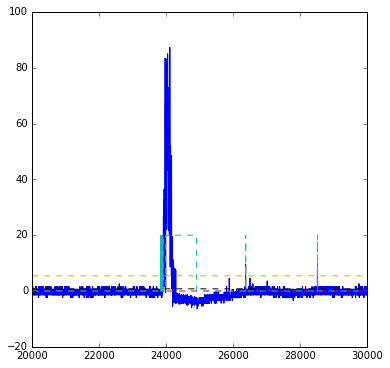

Press a key...
PMT number 5
thr1 = 7, thr2 = 1, thr3 = 1.0, mau length = 128
deconvoluting PMT = 4 with coef_clean = 3.138766e-06 coef_blr = 0.001566958
baseline = 2469.8515625 noise (LSB_rms) = 0.794566625304
trigger_line = 5.56196637713 trigger_off = 0.794566625304


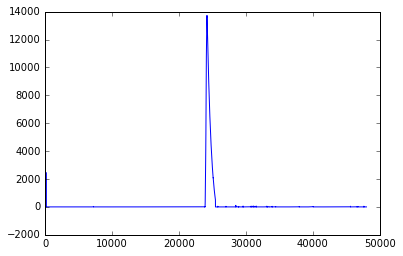

Press a key...


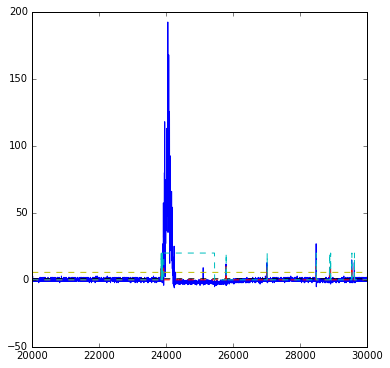

Press a key...
PMT number 6
thr1 = 7, thr2 = 1, thr3 = 1.0, mau length = 128
deconvoluting PMT = 5 with coef_clean = 3.965176e-06 coef_blr = 0.001649618
baseline = 2528.4140625 noise (LSB_rms) = 0.808686538359
trigger_line = 5.66080576851 trigger_off = 0.808686538359


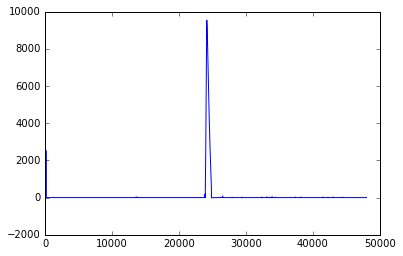

Press a key...


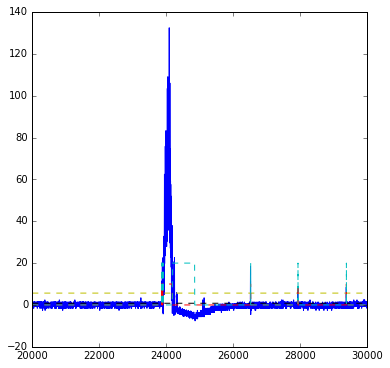

Press a key...
PMT number 7
thr1 = 7, thr2 = 1, thr3 = 1.0, mau length = 128
deconvoluting PMT = 6 with coef_clean = 2.711644e-06 coef_blr = 0.001592963
baseline = 2502.7265625 noise (LSB_rms) = 0.760385767718
trigger_line = 5.32270037403 trigger_off = 0.760385767718


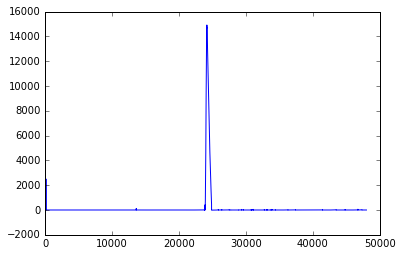

Press a key...


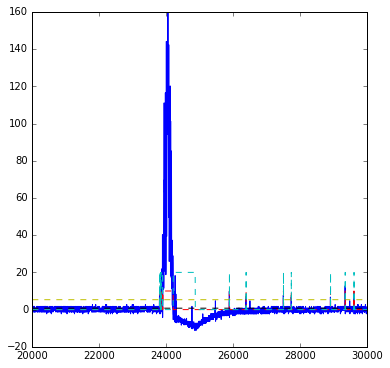

Press a key...
PMT number 8
thr1 = 7, thr2 = 1, thr3 = 1.0, mau length = 128
deconvoluting PMT = 7 with coef_clean = 3.127641e-06 coef_blr = 0.001612068
baseline = 2492.5390625 noise (LSB_rms) = 0.719824385298
trigger_line = 5.03877069708 trigger_off = 0.719824385298


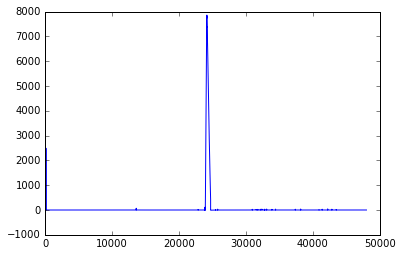

Press a key...


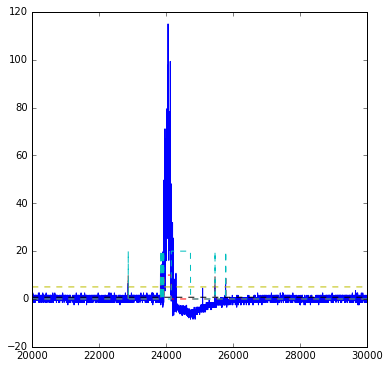

Press a key...
PMT number 9
thr1 = 7, thr2 = 1, thr3 = 1.0, mau length = 128
deconvoluting PMT = 8 with coef_clean = 3.064543e-06 coef_blr = 0.001600683
baseline = 2491.328125 noise (LSB_rms) = 0.743574840421
trigger_line = 5.20502388295 trigger_off = 0.743574840421


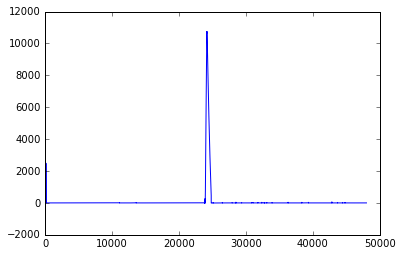

Press a key...


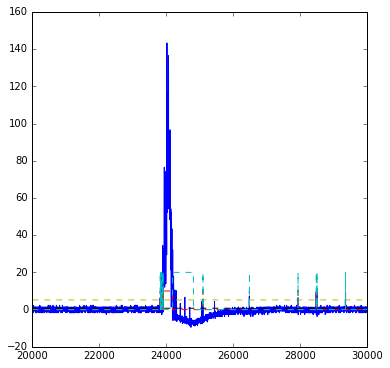

Press a key...
PMT number 10
thr1 = 7, thr2 = 1, thr3 = 1.0, mau length = 128
deconvoluting PMT = 9 with coef_clean = 3.040463e-06 coef_blr = 0.001592718
baseline = 2498.890625 noise (LSB_rms) = 0.77596143057
trigger_line = 5.43173001399 trigger_off = 0.77596143057


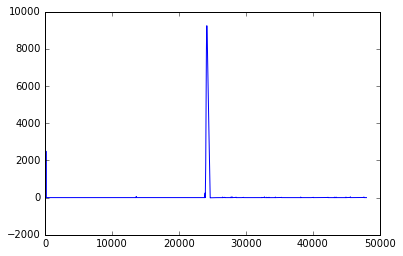

Press a key...


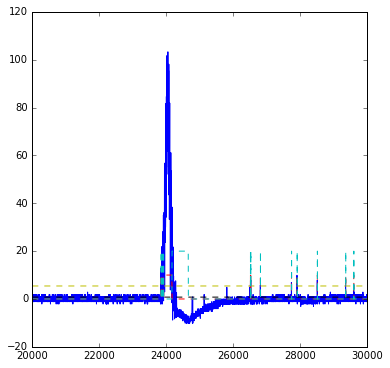

Press a key...
PMT number 11
thr1 = 7, thr2 = 1, thr3 = 1.0, mau length = 128
deconvoluting PMT = 10 with coef_clean = 3.113604e-06 coef_blr = 0.001575192
baseline = 2502.1015625 noise (LSB_rms) = 0.730007482973
trigger_line = 5.11005238081 trigger_off = 0.730007482973


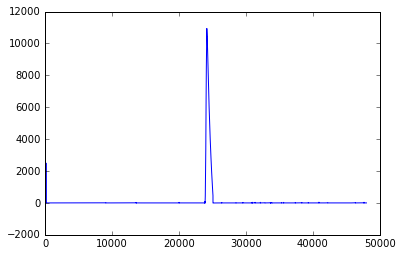

Press a key...


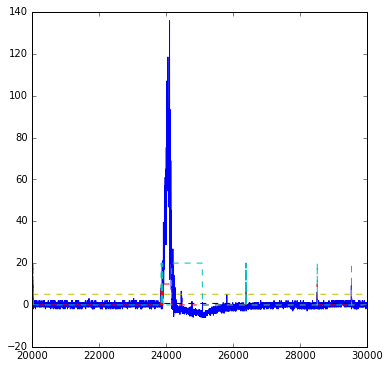

Press a key...
PMT number 12
thr1 = 7, thr2 = 1, thr3 = 1.0, mau length = 128
deconvoluting PMT = 11 with coef_clean = 3.185979e-06 coef_blr = 0.001596322
baseline = 2504.6796875 noise (LSB_rms) = 0.720166141702
trigger_line = 5.04116299191 trigger_off = 0.720166141702


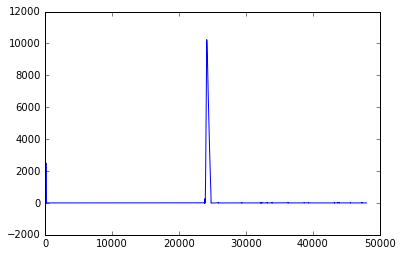

Press a key...


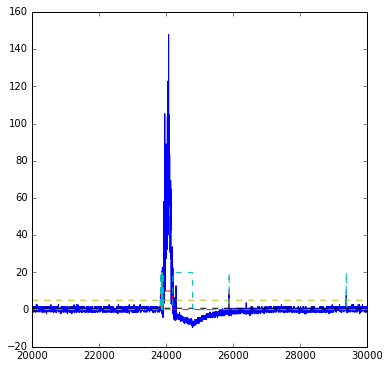

Press a key...


In [188]:
deconv_pmt(pmtrwf,dataPMT, thr1 = 7, thr2=1, thr3=1.0, mau_len=128, 
           xmin=20000,
           xmax=30000, event=0)

The best values for thr3 appear to be 0.3-0.5

Why some PMTs show a deep and others do not? Deconvolution coefficients?

## check with MC data

In [193]:
def fee_response(h5f, event=0, pmt=0):
    """
    returns:
    input function (after daq decimation)
    convoluted function (after FEE)
    recovered function (after cleaning filter and BLR)
    all in adc counts
    """
    pmtrd = h5f.root.pmtrd
    spe = FE.SPE()
    signal_i = FE.spe_pulse_from_vector(spe, pmtrd[event,pmt])  # in current units
    fee = FE.FEE(noise_FEEPMB_rms=1*FE.NOISE_I,noise_DAQ_rms=FE.NOISE_DAQ)
    signal_d = FE.daq_decimator(FE.f_mc, FE.f_sample, signal_i)
    signal_fee = FE.signal_v_fee(fee, signal_d)*FE.v_to_adc(fee)  #in adc counts
    signal_daq = FE.noise_adc(fee, signal_fee)
    
    return signal_d*FE.i_to_adc(fee), signal_daq

In [194]:
signal_d, signal_daq = fee_response(e40, event=0, pmt=0)

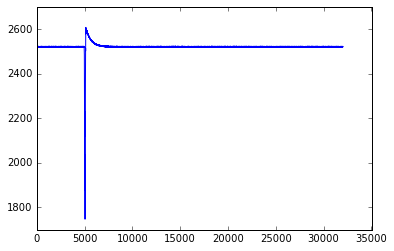

In [197]:
plt.plot(2520 - signal_daq)

In [198]:
fee = FE.FEE(noise_FEEPMB_rms=1*FE.NOISE_I,noise_DAQ_rms=FE.NOISE_DAQ)

In [199]:
freq_zero = 1./(fee.R1*fee.C1)
freq_zerod = freq_zero/(fee.f_sample*np.pi)
print('coef_c = {}'.format(freq_zerod))

coef_c = 1.87116159952e-06


In [200]:
print('coef_blr = {}'.format(fee.freq_LHPFd*np.pi)) 
    

coef_blr = 0.00192400951255


In [201]:
signal_i = 2520 - signal_daq

In [202]:
signal_r, BLR = deconvolve_signal(signal_i, mau_len=128, 
                                  coef_clean=freq_zerod, 
                                  coef_blr=fee.freq_LHPFd*np.pi, 
                                  thr1 = 5, thr2 = 0, thr3=0.3)

baseline = 2519.88790162 noise (LSB_rms) = 0.788901405222
trigger_line = 3.94450702611 trigger_off = 0.0


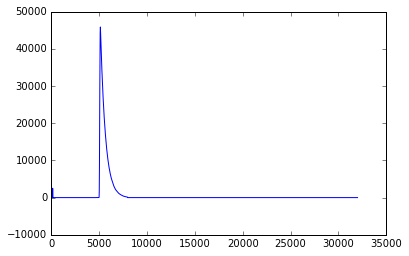

In [203]:
plt.plot(BLR['acum'])

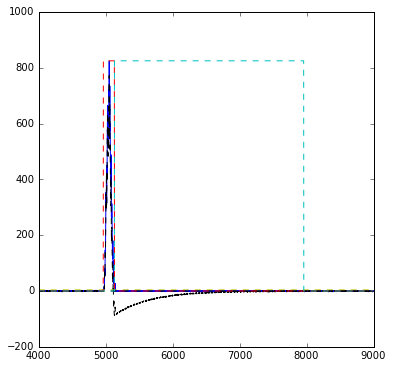

In [207]:
plt.figure(figsize=(6, 6))
xmin=4000
xmax=9000
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['trigger_2'][xmin:xmax],'k--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*BLR['sm'],'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*BLR['sm'],'c--', linewidth=1)

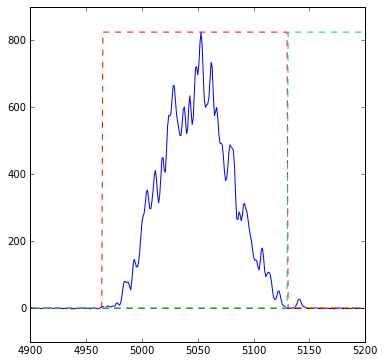

In [209]:
plt.figure(figsize=(6, 6))
xmin=4900
xmax=5200
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
#plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['trigger_2'][xmin:xmax],'k--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*BLR['sm'],'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*BLR['sm'],'c--', linewidth=1)

In [210]:
e_mc = np.sum(signal_r[4950:5150])

In [212]:
e_mc/20.

2632.6860907737205

In [213]:
signal_r, BLR = deconvolve_signal(pmtrwf[0,5], mau_len=128, 
                                  coef_clean=dataPMT['coef_c'][5], 
                                  coef_blr=dataPMT['coef_blr'][5], 
                                  thr1 = 5, thr2 = 0, thr3=0.3, filter_c=True,
                                  kmin=23850, kmax=23850)

baseline = 2528.4140625 noise (LSB_rms) = 0.808686538359
trigger_line = 4.04343269179 trigger_off = 0.0


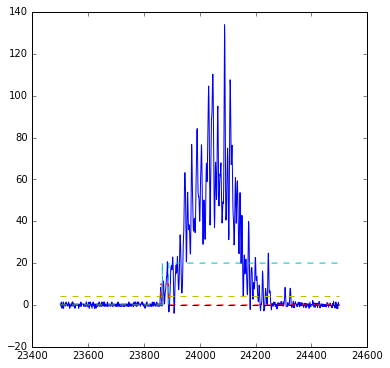

In [215]:
plt.figure(figsize=(6, 6))
xmin=23500
xmax=24500
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
#plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['trigger_2'][xmin:xmax],'k--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*20,'c--', linewidth=1)

In [216]:
e_data = np.sum(signal_r[23859:24250])

In [217]:
e_data/20.

694.04030732790432

In [218]:
e_mc/e_data

3.79327549564047

There seems to be a factor 4 less light in the data than in the MC!

In [219]:
pmtrd = e40.root.pmtrd

In [220]:
np.sum(pmtrd[0,0])

1210

In [221]:
def get_energy(pmtea, event_list=[0]):
    """
    Takes the earray pmtea and a list of events and returns a DF
    with the sum of the energies for event_number
    """
    NPMT = pmtea.shape[1]
    epmt = np.zeros(NPMT)
    EPMT = []

    for i in event_list:
        for j in range(NPMT):
            epmt[j] = np.sum(pmtea[i, j])
        EPMT.append(epmt)

    return pd.DataFrame(EPMT)

In [222]:
epmtdf = get_energy(pmtrd, event_list=range(900))

(array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,  900.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.]),
 array([ 1263.5 ,  1263.54,  1263.58,  1263.62,  1263.66,  1263.7 ,
         1263.74,  1263.78,  1263.82,  1263.86,  1263.9 ,  1263.94,
         1263.98,  1264.02,  1264.06,  1264.1 ,  1264.14,  1264.18,
         1264.22,  1264.26,  1264.3 ,  1264.34,  1264.38,  1264.42,
         1264.46,  1264.5 ]),
 <a list of 25 Patch objects>)

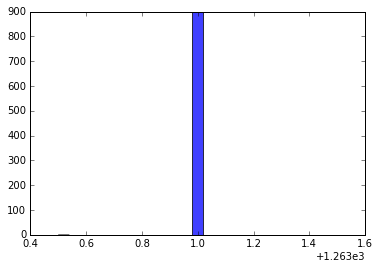

In [224]:
plt.hist(epmtdf[1], 25, histtype="bar", alpha=0.75)